In [35]:
# This notebook identifies a golfball in radar data
# range_doppler_notebook has the basics of how to get the basics

import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftshift # Might not need this
from radar_ffts import range_doppler_fft, range_doppler_sum
from cfar import cfar, clean_cfar

c = 299792458 # metres per second - need this

In [36]:
# Gets data about the h5py file, and stores it
def get_measurement_parameters(hdf5_file_path):
    freq_slope_const = hdf5_file_path['Sensors/TI_Radar/Parameters/profileCfg/freqSlopeConst'][()] # In MHz per microsecond
    chirp_start_index = hdf5_file_path['Sensors/TI_Radar/Parameters/frameCfg/chirpStartIndex'][()]
    chirp_end_index = hdf5_file_path['Sensors/TI_Radar/Parameters/frameCfg/chirpEndIndex'][()]
    frame_period = hdf5_file_path['Sensors/TI_Radar/Parameters/frameCfg/framePeriod'][()]
    ramp_end_time = hdf5_file_path['Sensors/TI_Radar/Parameters/profileCfg/rampEndTime'][()]
    start_freq = hdf5_file_path['Sensors/TI_Radar/Parameters/profileCfg/startFreq'][()]
    number_of_samples_per_chirp = hdf5_file_path['Sensors/TI_Radar/Parameters/profileCfg/numAdcSamples'][()]
    sample_rate = hdf5_file_path['Sensors/TI_Radar/Parameters/profileCfg/digOutSampleRate'][()] # in ks per second

    Tdata = number_of_samples_per_chirp * 1/(sample_rate*1000)
    # From this we can find bandwidth with B = Tdata * frequency_slope_constant
    bandwidth = Tdata * freq_slope_const * 1e6 * 1e6 # This leaves it in Hz

    # From these we know c and can calculate the range bin size
    range_bin_size = c/(2*bandwidth)
    return freq_slope_const, number_of_samples_per_chirp, sample_rate, Tdata, bandwidth, range_bin_size

In [37]:
# Generates a range doppler map of hdf5 radar data. Can make a plot or just the data
def range_doppler_map(hdf5_file_path, frame, range_bin_size, make_map):
    
    frame_data = hdf5_file_path[f'Sensors/TI_Radar/Data/Frame_{frame}/frame_data']
    #print(frame_data[0,:,0]) # data is stored as samples x chirps x channels
    range_pad = 0
    doppler_pad = 0

    fftd_frame_data = range_doppler_fft(frame_data, range_pad, doppler_pad)

    plotted_fftd_frame_data = range_doppler_sum(fftd_frame_data)

    plotted_fftd_frame_data=np.flip(plotted_fftd_frame_data, 0)
#    print(plotted_fftd_frame_data.shape)
    if make_map:
        plt.figure()
        plt.imshow(plotted_fftd_frame_data, aspect='auto', cmap='jet')
        plt.title('Range-Doppler Map')
        plt.xlabel('Doppler')
        plt.ylabel('Range')
        plt.colorbar(label='Power (dB)')
        # Get current y-ticks and labels
        y_ticks = plt.gca().get_yticks()
        plt.gca().set_yticklabels(y_ticks[::1]*range_bin_size) #TODO: Figure out how to relabel the data, not just the ticks
        plt.show()
        
    return plotted_fftd_frame_data

In [38]:
def cfar_map(range_doppler_data, make_map):

    cfar_output = cfar((10**(range_doppler_data/20)), 3, 3, 2, 2, 1e-4,0)

    if make_map:
        plt.figure()
        plt.imshow(cfar_output, aspect='auto', cmap='jet')
        #plt.imshow(20 * np.log10(np.abs(after_slow_time_fft)), aspect='auto', cmap='jet')
        plt.title('CFAR Map')
        plt.xlabel('Doppler')
        plt.ylabel('Range')
        plt.colorbar(label='Power (dB)')
        plt.show()
    return cfar_output

In [41]:
# Making data lists
moving_back_test = h5py.File('../4022S_data/undergrad_testset/Experiment_moving_target_back_data.hdf5', 'r') # Read in the file
one_meter_centre_test = h5py.File('../4022S_data/undergrad_testset/Experiment_stationary_target_1m_1_data.hdf5','r')
two_meter_centre_test = h5py.File('../4022S_data/undergrad_testset/Experiment_stationary_target_2m_1_data.hdf5','r')

preface = '../4022S_data/golfball_testset1/'

# There is CERTAINLY a way to do this faster but I dont have internet rn so oh well :/
# TODO: Find the right thing to do this
initial_slow_tests = [h5py.File(f'{preface}Experiment_2024-09-13_14-13-34_932_initialgolftest_slow.hdf5','r'),
                      h5py.File(f'{preface}Experiment_2024-09-13_14-14-00_080_initialgolftest_slow.hdf5','r'),
                      h5py.File(f'{preface}Experiment_2024-09-13_14-14-17_789_initialgolftest_slow.hdf5','r'),
                      h5py.File(f'{preface}Experiment_2024-09-13_14-14-35_509_initialgolftest_slow.hdf5','r'),
                      h5py.File(f'{preface}Experiment_2024-09-13_14-14-50_154_initialgolftest_slow.hdf5','r'),
                      h5py.File(f'{preface}Experiment_2024-09-13_14-15-40_120_initialgolftest_slow.hdf5','r'),
                      h5py.File(f'{preface}Experiment_2024-09-13_14-15-55_306_initialgolftest_slow.hdf5','r')]

initial_fast_tests = [h5py.File(f'{preface}Experiment_2024-09-13_14-17-13_795_initialgolftest_fast.hdf5'),
                      h5py.File(f'{preface}Experiment_2024-09-13_14-18-01_884_initialgolftest_fast.hdf5'),
                      h5py.File(f'{preface}Experiment_2024-09-13_14-18-18_495_initialgolftest_fast.hdf5'),
                      h5py.File(f'{preface}Experiment_2024-09-13_14-18-35_886_initialgolftest_fast.hdf5'),
                      h5py.File(f'{preface}Experiment_2024-09-13_14-19-20_774_initialgolftest_fast.hdf5'),
                      h5py.File(f'{preface}Experiment_2024-09-13_14-19-34_102_initialgolftest_fast.hdf5'),
                      h5py.File(f'{preface}Experiment_2024-09-13_14-19-47_106_initialgolftest_fast.hdf5'),]


C:\Users\harry\AppData\Local\Temp\ipykernel_21120\1361190094.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(y_ticks[::1]*range_bin_size) #TODO: Figure out how to relabel the data, not just the ticks


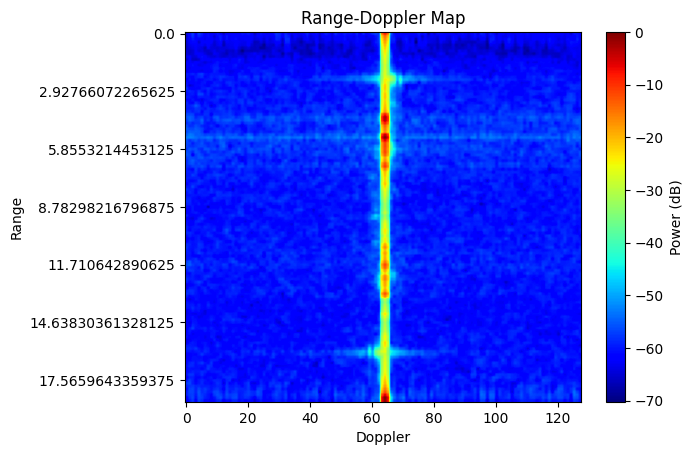

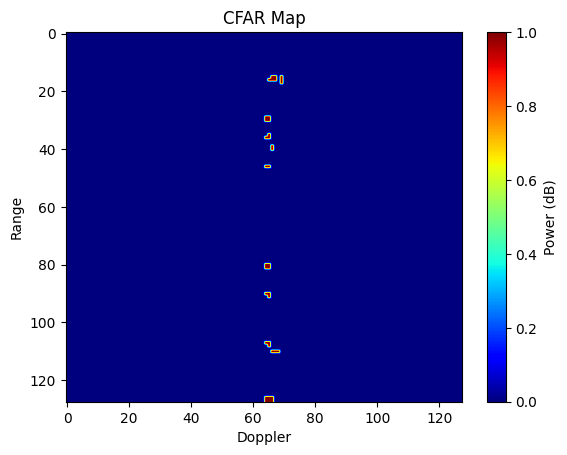

In [46]:
test_in_question = initial_fast_tests[0]
freq_slope_const, number_of_samples_per_chirp, sample_rate, Tdata, bandwidth, range_bin_size = get_measurement_parameters(test_in_question)
range_doppler_data = range_doppler_map(test_in_question, '2', range_bin_size, 1)
cfar_data = cfar_map(range_doppler_data, 1)